In [19]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

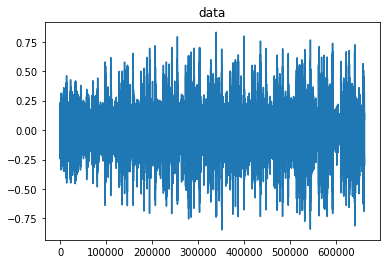

In [20]:
data, rate = librosa.load('genres/disco/disco.00021.wav') 

def show_data(data):
    plt.figure()
    plt.title("data")
    plt.plot(data)
    plt.show()

    
show_data(data)
ipd.Audio(data, rate=22050)

before transform  [-111.83415875 -115.01071369 -104.59945413  -77.55096798  -76.88993363
  -82.95680326  -83.04131269  -84.46004362  -99.52774672 -112.93727887]


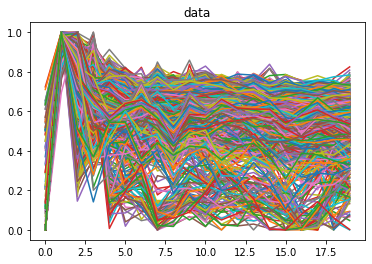

mfcc shape  (20, 1293)


In [21]:
data = librosa.feature.mfcc(data)
print('before transform ', data[0][:10])
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data)
data = scaler.transform(data)

show_data(data)
print('mfcc shape ', data.shape)

In [22]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

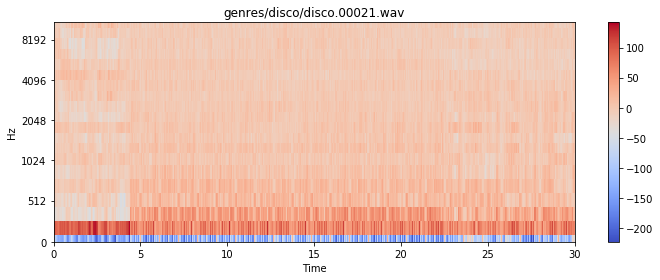

In [23]:
display_mfcc('genres/disco/disco.00021.wav')

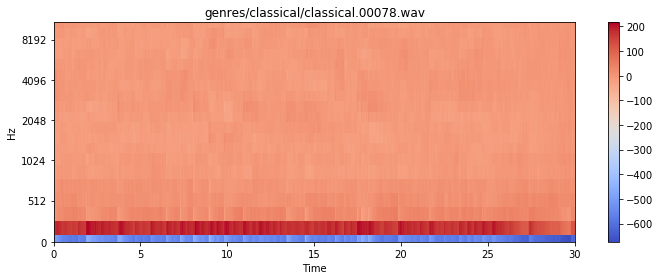

In [24]:
display_mfcc('genres/classical/classical.00078.wav')

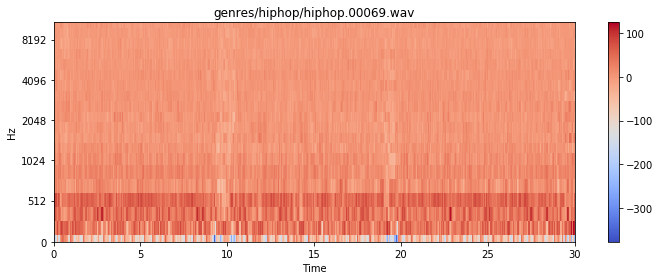

In [25]:
display_mfcc('genres/hiphop/hiphop.00069.wav')

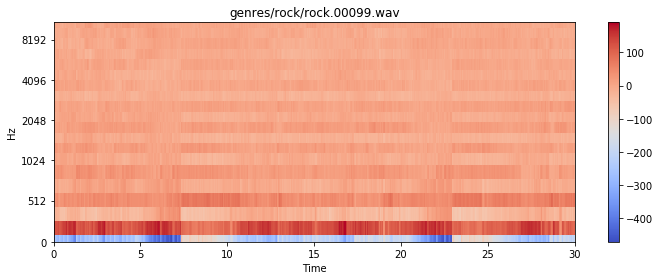

In [26]:
display_mfcc('genres/rock/rock.00099.wav')

In [12]:
def extract_features_song(f):
    x, sr = librosa.load(f)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(x)
    # normalize values between -1,1 (divide by max)
    mfcc = mfcc/np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:1000]

In [27]:
def generate_features_and_labels():
    all_features = []
    all_labels = []

    genres = ['blues', 'classical', 'country', 'disco', 'hiphop']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [28]:
#passing parameter dari fitur ekstraksi menggunakan mfcc
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...


In [15]:
print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# last column has genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))

train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(np.shape(train_input))
print(np.shape(train_labels))

(500, 1000)
(500, 5)
(400, 1005)
(100, 1005)
(400, 995)
(400, 10)


In [18]:
model = Sequential([
    Dense(100, input_dim=np.shape(train_input)[1]),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

model.fit(train_input, train_labels, epochs=10, batch_size=32,
          validation_split=0.2)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print("Done!")
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               99600     
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 100,610
Trainable params: 100,610
Non-trainable params: 0
_________________________________________________________________
None
Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 1s 4ms/step - loss: -15.6650 - accuracy: 0.1750 - val_loss: -34.2161 - val_accuracy: 0.1875
Epoch 2/10
320/320 [==============================